In [760]:
import nltk
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords, brown
from torch.utils.data import TensorDataset, DataLoader
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dotronghiep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [761]:
import pandas as pd

df = pd.read_csv('/home/dotronghiep/Documents/Datasets/Social_Listening/DataLabel.csv', header=None)
df.head(10)

,0,1,2
0,1,0,impossible to stop basically means russia is n...
1,2,0,indeed. may russia soil then selves in terror ...
2,3,0,"goodnight family, thanks to everyone for your ..."
3,4,0,keep adding more sanctionsfastest way to get r...
4,5,0,russia does not get to rape ukraine in order t...
5,6,1,its already done de facto. east ukraineand cri...
6,7,1,russia takes most of sievierodonetsk city in e...
7,8,0,biden says us to send ukraine 'advanced rocket...
8,9,1,just in - biden us to send ukraine advanced ro...
9,10,0,why do you suppose i do not understand that. i...


In [762]:
X_row = df.iloc[:, 2].values
y = df.iloc[:, 1].values

In [763]:
# Xác định số lượng mẫu của mỗi lớp
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(class_0_count,class_1_count)

4108 1663


In [764]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_row, y, test_size=0.2, random_state=42, stratify=y)

# Train the model

In [765]:
print(len(X_train))

4616


In [766]:
print(len(y_train))

4616


In [767]:
# lấy danh sách stopword
stop = set(stopwords.words('english'))
# stop = ()
brown_words = set(word for word in brown.words() if word.lower() not in stop)|{"biden",
                                                                               "ukraine","kiev","kyiv","zelensky", "ukrainian", "ukrainians",
                                                                               "putin","kremlin", "russia", "russian", "russians",
                                                                               "not", "no", "nor", "against", "never", "nobody", "none", "nowhere"}

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

In [768]:
def lemma(text):
    words = tokenizer.tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word, pos='v') for word in words if word in brown_words]
    return cleaned_words


# Loại bỏ stop words từ mỗi văn bản trong danh sách X
X_cleaned = [lemma(text) for text in X_train]
X_full = [lemma(text) for text in X_row]

In [769]:
X_cleaned[:10]

[['ukraine', 'every', 'right', 'attack', 'russia', 'point'],
 ['real', 'men', 'defend', 'country', 'people', 'respect'],
 ['well',
  'honest',
  'russian',
  'visit',
  'board',
  'quite',
  'time',
  'russia',
  'start',
  'military',
  'build',
  'ukraine',
  'border',
  'last',
  'year',
  'call',
  'journalist'],
 ['poor',
  'russian',
  'regime',
  'world',
  'say',
  'no',
  'brutal',
  'invasion',
  'play',
  'victim',
  'get',
  'ukraine'],
 ['definitely', 'arm', 'ukraine', 'teeth', 'keep', 'russia'],
 ['legitimate',
  'security',
  'concern',
  'already',
  'countries',
  'members',
  'military',
  'base',
  'nuclear',
  'capability',
  'wipe',
  'russia',
  'map',
  'ukraine',
  'make',
  'zero',
  'difference',
  'putin',
  'know',
  'join',
  'could',
  'not',
  'invade',
  'point'],
 ['ukraine',
  'shut',
  'listen',
  'russia',
  'like',
  'shut',
  'listen',
  'us',
  'argue',
  'otherwise',
  'accept',
  'kind',
  'absurd',
  'prevalent',
  'among',
  'riddle',
  'cat',

In [770]:
import torch
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

In [771]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [772]:
max_length = max(len(sentence) for sentence in X_cleaned)
max_length

36

In [773]:
model = Word2Vec(X_full, 
                 vector_size=100, 
                 window=9, 
                 min_count=5, 
                 workers=8, 
                 epochs=50)
vocabulary = model.wv.index_to_key
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 2000


In [774]:
# Tìm từ gần nhất 
similar_words = model.wv.most_similar("putin")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

madness: 0.3889
lion: 0.3885
prison: 0.3746
weak: 0.3732
dictator: 0.3707
murderous: 0.3674
bully: 0.3539
damn: 0.3507
tire: 0.3457
everyone: 0.3378


In [775]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def vectorize(X, y, model=model):
    X_vectors = []
    y_vectors = []
    # Chuyển từng từ trong mỗi câu thành vector biểu diễn và thêm padding
    for sentence, label in zip(X, y):
        if len(sentence) < 5:
            continue

        sentence_vectors = []
        for word in sentence:
            # Kiểm tra xem từ đó có trong từ vựng của mô hình Word2Vec hay không
            if word in model.wv:
                word_vector = model.wv[word]
                sentence_vectors.append(word_vector)
            else:
                # Nếu từ không có trong từ vựng, bạn có thể sử dụng một vector thay thế hoặc bỏ qua nó
                # Ví dụ: word_vector = np.zeros((vector_size,))
                pass

        # Thêm padding cho câu để độ dài của mỗi câu là 35
        while len(sentence_vectors) < 35:
            sentence_vectors.append(np.zeros((100,)))  # Sử dụng vector zeros cho padding

        # Chuyển danh sách các vector thành một tensor
        sentence_tensor = torch.tensor(sentence_vectors)
        # Thêm câu đã được padding vào danh sách X_vectors
        X_vectors.append(sentence_tensor)
        y_vectors.append(label)


    # Chuyển danh sách X_vectors thành một tensor
    X_padded = np.array(X_vectors)
    y_padded = np.array(y_vectors)
    return X_padded, y_padded
# In ra kích thước của X_padded
X_input, y_input = vectorize(X_cleaned, y_train)
print(X_input.shape)
print(y_input.shape)


(4437, 35, 100)
(4437,)


In [807]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sofmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Khởi tạo hidden state và cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Đưa đầu vào qua LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output của lớp cuối cùng
        out = self.dropout(out)
        out = self.fc1(out[:, -1, :])
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.sofmax(out)
        return out

# Định nghĩa các siêu tham số
input_size = 100  # Kích thước của vectơ biểu diễn từ
hidden_size = 64  # Kích thước của hidden state trong LSTM
num_layers = 3  # Số lớp LSTM xếp chồng lên nhau
num_classes = 2  # Số lớp đầu ra
num_epochs = 100  # Số epoch
lr = 0.001
batch_size = 256

In [808]:
def train_lstm(X_input, y_input, num_epochs=num_epochs):    
    # Khởi tạo mô hình
    lstm = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)
    lstm.to(device)

    X_train, X_valid, y_train, y_valid = train_test_split(X_input, y_input, test_size=0.2, random_state=42, stratify=y_input)

    # Xác định số lượng mẫu của mỗi lớp
    class_0_count = np.sum(y_train == 0)
    class_1_count = np.sum(y_train == 1)
    # Tính toán số lượng mẫu cần thêm vào mỗi lớp để làm cho số lượng mẫu của hai lớp bằng nhau
    sample_diff = abs(class_0_count - class_1_count)
    samples_to_add = max(class_0_count, class_1_count) - min(class_0_count, class_1_count)

    # Lấy mẫu ngẫu nhiên từ các mẫu hiện có trong lớp ít mẫu để tạo ra số lượng mẫu cần thiết và thêm vào tập train
    if class_0_count < class_1_count:
        X_train_class_0 = X_train[y_train == 0]
        y_train_class_0 = y_train[y_train == 0]
        additional_indices = np.random.choice(range(class_0_count), samples_to_add)
        X_train_additional = X_train_class_0[additional_indices]
        y_train_additional = y_train_class_0[additional_indices]
        X_train = np.concatenate((X_train, X_train_additional))
        y_train = np.concatenate((y_train, y_train_additional))
    else:
        X_train_class_1 = X_train[y_train == 1]
        y_train_class_1 = y_train[y_train == 1]
        additional_indices = np.random.choice(range(class_1_count), samples_to_add)
        X_train_additional = X_train_class_1[additional_indices]
        y_train_additional = y_train_class_1[additional_indices]
        X_train = np.concatenate((X_train, X_train_additional))
        y_train = np.concatenate((y_train, y_train_additional))

    # Trộn lại dữ liệu để đảm bảo tính ngẫu nhiên
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train).to(device)
    y_valid = torch.tensor(y_valid).to(device)

    # Tạo DataLoader cho dữ liệu train và validation
    train_dataset = TensorDataset(X_train, y_train)

    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Vòng lặp huấn luyện
    losses_train = []
    losses_valid = []
    accuracies = []
    for epoch in range(1, num_epochs + 1):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Huấn luyện
        lstm.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = lstm(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # In ra loss sau mỗi 5 eclass_0_count = np.sum(predicted_labels == 0)
        if epoch % 5 == 0:

            # Đánh giá mô hình trên tập validation
            lstm.eval()
            with torch.no_grad():
                # for X_batch, y_batch in valid_loader:
                outputs_train = lstm(X_train)
                loss_train = criterion(outputs_train, y_train)
                losses_train.append(loss_train.item())
                print(f"Epoch {epoch}, Loss train: {loss_train.item()}")

                outputs_valid = lstm(X_valid)
                loss_valid = criterion(outputs_valid, y_valid)
                losses_valid.append(loss_valid.item())
                print(f"Epoch {epoch}, Loss validate: {loss_valid.item()}")

            _, predicted = torch.max(outputs_valid, 1)
            predicted_labels = predicted.cpu().numpy()
            true_labels = y_valid.cpu().numpy()
            accuracy = accuracy_score(true_labels, predicted_labels)
            accuracies.append(accuracy)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1 Score:", f1)

            print("=========================================")
    return lstm, losses_train, losses_valid, accuracies

In [809]:
lstm, losses_train, losses_valid, accuracies = train_lstm(X_input, y_input)

Epoch 5, Loss train: 0.6433873772621155
Epoch 5, Loss validate: 0.648680567741394
Accuracy: 0.6238738738738738
Precision: 0.38823529411764707
Recall: 0.5116279069767442
F1 Score: 0.4414715719063546
Epoch 10, Loss train: 0.49023786187171936
Epoch 10, Loss validate: 0.6694823503494263
Accuracy: 0.6531531531531531
Precision: 0.4161073825503356
Recall: 0.4806201550387597
F1 Score: 0.4460431654676259
Epoch 15, Loss train: 0.35675328969955444
Epoch 15, Loss validate: 0.7111566066741943
Accuracy: 0.6813063063063063
Precision: 0.4458874458874459
Recall: 0.3992248062015504
F1 Score: 0.42126789366053174
Epoch 20, Loss train: 0.274136483669281
Epoch 20, Loss validate: 0.7957527041435242
Accuracy: 0.6891891891891891
Precision: 0.46017699115044247
Recall: 0.40310077519379844
F1 Score: 0.4297520661157025
Epoch 25, Loss train: 0.24780791997909546
Epoch 25, Loss validate: 0.9524704813957214
Accuracy: 0.6644144144144144
Precision: 0.42592592592592593
Recall: 0.44573643410852715
F1 Score: 0.435606060606

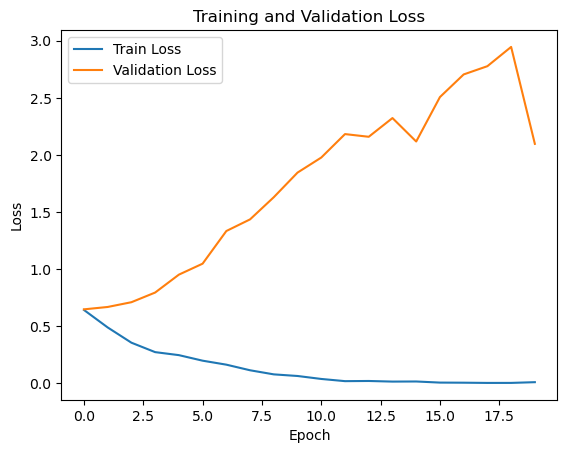

In [810]:
plt.plot(losses_train, label='Train Loss')
plt.plot(losses_valid, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Test

In [811]:
X_test_cleaned = [lemma(text) for text in X_test]
test_max_length = max(len(sentence) for sentence in X_test_cleaned)
print(test_max_length)

31


In [812]:
X_test_vector, y_test_vector = vectorize(X_test_cleaned, y_test)
print(X_test_vector.shape)
print(y_test_vector.shape)

(1104, 35, 100)
(1104,)


In [813]:
outputs_test = lstm(torch.tensor(X_test_vector, dtype=torch.float32).to(device))

_, predicted = torch.max(outputs_test, 1)
predicted_labels = predicted.cpu().numpy()
true_labels = y_test_vector
accuracy = accuracy_score(true_labels, predicted_labels)
accuracies.append(accuracy)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6530797101449275
Precision: 0.39935064935064934
Recall: 0.38317757009345793
F1 Score: 0.39109697933227344


In [814]:
# Convert the predicted labels to a numpy array
predicted_labels = np.array(predicted_labels)

# Count the number of occurrences of each class
class_counts = np.bincount(predicted_labels)

# Print the class counts
for class_label, count in enumerate(class_counts):
    print(f"Class {class_label}: {count}")


Class 0: 796
Class 1: 308
